In [172]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, get_scorer_names, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from xgboost import XGBClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from statistics import mode as md
from matplotlib import pyplot as plt
from IPython.display import clear_output
from collections import Counter

In [173]:
testing = pd.read_csv("tanzanian_water_wells/X_test.csv")
X = pd.read_csv("tanzanian_water_wells/X_train.csv")
y = pd.read_csv("tanzanian_water_wells/y_train.csv")['status_group'].map({'functional': 0, 'functional needs repair': 1, 'non functional': 2})

In [174]:
X = X.drop(['id', 'wpt_name', 'subvillage', 'installer', 'funder', 'scheme_name', 'ward', 'date_recorded', 'recorded_by'], axis=1)
testing = testing.drop(['id', 'wpt_name', 'subvillage', 'installer', 'funder', 'scheme_name', 'ward', 'date_recorded', 'recorded_by'], axis=1)

In [175]:
# Eliminating null values from X_train
X.scheme_management.fillna("None", inplace=True)
X.permit.fillna('Unknown', inplace=True)
X.public_meeting.fillna('Unknown', inplace=True)

In [176]:
# X['public_meeting'] = X['public_meeting'].map({True: 'Yes', False: 'No', 'Unknown': 'Unknown'})
X['permit'] = X['permit'].map({True: 'Yes', False: 'No', 'Unknown': 'Unknown'})
X['gps_height'] = X['gps_height'].astype('float64')
# X['district_code'] = X['district_code'].astype('float64')
X['population'] = X['population'].astype('float64')
X['construction_year'] = X['construction_year'].astype('int64')
X['region_code'] = X['region_code'].astype('str')
X['district_code'] = X['district_code'].astype('str')

X_cat = X.select_dtypes(exclude=['float64', 'int64'])
X_cat = X_cat.astype('str')
X_numeric = X.select_dtypes(['float64', 'int64'])

In [177]:
X_cat = X_cat.drop(['quantity', 'waterpoint_type_group', 'extraction_type_group', 
                    'region', 'extraction_type', 'payment_type', 'source_type', 
                    'management_group', 'water_quality', 'source_class', 
                    'region_code', 'district_code'], axis=1)

testing = testing.drop(['quantity', 'waterpoint_type_group', 'extraction_type_group', 
                    'region', 'extraction_type', 'payment_type', 'source_type', 
                    'management_group', 'water_quality', 'source_class', 
                    'region_code', 'district_code'], axis=1)

In [178]:
X_cat = pd.get_dummies(X_cat)

In [179]:
scaler = StandardScaler()
scaler.fit(X_numeric)
X_numeric = pd.DataFrame(scaler.transform(X_numeric), columns = X_numeric.columns, index = X_numeric.index)

In [180]:
X = pd.concat([X_numeric, X_cat], axis=1)

In [181]:
df = pd.concat([X, y], axis=1)

In [182]:
estimators = {'logreg': LogisticRegression(solver='liblinear', fit_intercept=False), 
              'dtc': DecisionTreeClassifier(), 
              'knn': KNeighborsClassifier(n_neighbors=3), 
              'bg_clf': BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, max_features=50), 
              'forest': RandomForestClassifier(), 
              'xgb': XGBClassifier(), 
              'adaboost': AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42), 
              'gb_clf': GradientBoostingClassifier(random_state=42, n_estimators=200, max_features=50), 
              'extra_trees': ExtraTreesClassifier(n_estimators=100, random_state=42), 
              'stck': StackingClassifier(
        estimators = [('logistic_regression', LogisticRegression(solver='liblinear', fit_intercept=False)), 
                      ('bagging_classifier', BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, max_features=50))], 
        final_estimator = XGBClassifier())}

In [183]:
strategy = {1: 20000}
smote = SMOTE()

X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = smote.fit_resample(X_test, y_test) #don't need

X_train_resampled = X_train_resampled.reset_index(drop=True)
X_test_resampled = X_test_resampled.reset_index(drop=True) #don't need
y_train_resampled = y_train_resampled.reset_index(drop=True)
y_test_resampled = y_test_resampled.reset_index(drop=True) #don't need

df_resampled = pd.concat([X_train_resampled, y_train_resampled], axis=1)

f = df_resampled[df_resampled.status_group == 0].reset_index(drop=True).copy()
nf = df_resampled[df_resampled.status_group == 2].reset_index(drop=True).copy()
fnr = df_resampled[df_resampled.status_group == 1].reset_index(drop=True).copy()

f = f.sample(frac=1)
nf = nf.sample(frac=1)
fnr = fnr.sample(frac=1)

fs = [pd.DataFrame(i) for i in np.array_split(f, len(f)//1000)]
nfs = [pd.DataFrame(i) for i in np.array_split(nf, len(nf)//1000)]
fnrs = [pd.DataFrame(i) for i in np.array_split(fnr, len(fnr)//1000)]

resamples = []

for i in range(len(fnrs)):
    resample = pd.concat([fs[i], nfs[i], fnrs[i]])
    resamples.append(resample)

In [184]:
master_preds = []

for est in estimators.values():

    models = []
    preds = []
    modes=[]
    counters=[]
    dfs = []

    for i in range(len(resamples)):
        estimator =  est
        X = resamples[i].drop(['status_group'], axis=1)
        y = resamples[i]['status_group']
        estimator.fit(X, y)
        pred = estimator.predict(X_test)
        preds.append(pred)
        models.append(estimator)
        
        clear_output(wait=True)
        print(f"Sample: #{i}")
        print(f"Estimator: {est}")
        clear_output(wait=True)


    for i in range(len(preds[0])):
        mode = md([pred[i] for pred in preds])
        counter = Counter([pred[i] for pred in preds])
        counters.append(counter)
        modes.append(mode)

    pred_df = pd.DataFrame({n: preds[n] for n in range(len(preds))})
    pred_df['mode'] = modes
    pred_df['original'] = y_test
    dfs.append(pred_df)
    
    master_preds.append(modes)

Sample: #23
Estimator: StackingClassifier(estimators=[('logistic_regression',
                                LogisticRegression(fit_intercept=False,
                                                   solver='liblinear')),
                               ('bagging_classifier',
                                BaggingClassifier(estimator=DecisionTreeClassifier(),
                                                  max_features=50,
                                                  n_estimators=50))],
                   final_estimator=XGBClassifier(base_score=None, booster=None,
                                                 callbacks=None,
                                                 colsample_bylevel=None,
                                                 colsample_bynode=None,
                                                 colsamp...
                                                 gpu_id=None, grow_policy=None,
                                                 importance_type=None,

In [185]:
master_pred_df = pd.DataFrame({list(estimators.keys())[i]: master_preds[i] for i in range(len(master_preds))})

master_modes = []

for i in range(len(master_preds[0])):
    mode = md([master_pred[i] for master_pred in master_preds])
    counter = Counter([master_pred[i] for master_pred in master_preds])
    counters.append(counter)
    master_modes.append(mode)

master_pred_df['mode'] = master_modes
master_pred_df['original'] = y_test

matrix_labels = ['functional', 'functional needs repair', 
                 'non functional']

matrix = pd.DataFrame(confusion_matrix(master_pred_df['mode'], y_test), columns=matrix_labels, index=matrix_labels)
report = pd.DataFrame(classification_report(master_pred_df['mode'], y_test, output_dict=True))

In [186]:
matrix

,functional,functional needs repair,non functional
functional,6019,215,1256
functional needs repair,1338,729,558
non functional,687,108,3940


In [187]:
report

,0,1,2,accuracy,macro avg,weighted avg
precision,0.748260,0.692966,0.684741,0.719731,0.708655,0.718232
recall,0.803605,0.277714,0.832101,0.719731,0.637807,0.719731
f1-score,0.774945,0.396519,0.751263,0.719731,0.640909,0.700501
support,7490.000000,2625.000000,4735.000000,0.719731,14850.000000,14850.000000


In [188]:
master_pred_df.drop(['mode', 'original'], axis=1).corr().mean()

logreg         0.761048
dtc            0.787200
knn            0.728264
bg_clf         0.810855
forest         0.835966
xgb            0.821709
adaboost       0.792570
gb_clf         0.799033
extra_trees    0.810397
stck           0.818594
dtype: float64

<Axes: >

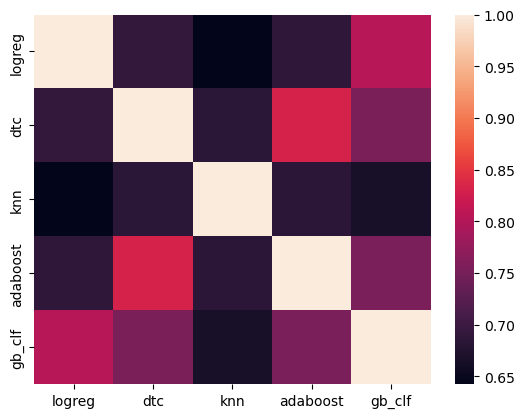

In [194]:
sns.heatmap(master_pred_df.drop(['mode', 'original'], axis=1).corr())